### Description:  This script produces Figure 8 (violin plots of (a) flash initiation rates, and (b) mean flash area within and outside Z$_{DR}$ column regions )

In [1]:
import glob
import os
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyart
import skimage
import xarray as xr
from skimage import io
from skimage.measure import label, regionprops, regionprops_table

from may19_2013_obs_analysis.wsr88d_parsing import (
    ceil,
    distance_from_radar,
    extent_of_interest,
    get_xarray_dataset,
    grab_time_intervals,
    interval,
    scan_vol_time,
    sec2time,
)

matplotlib.rc("xtick", labelsize=15)
matplotlib.rc("ytick", labelsize=15)

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# load segmented files (containing identified and labelled ZDR columns). These segmented files were obtained by applying Allen
# segmentation tool directly on numpy array data rather than saving ZDR cross-section plots as tiff images.

# The numpy array were used to be consistent with the coordinates to identify exact loaction in terms of array elements. There is a small
# tradeoff in using segmentation over numpy array instead of tiff images (in terms of some discrepancies in full identification
# of ZDR column objects). However,for the purposes of this statistical analysis, we did not find much performance degradation.

segmented_files = sorted(
    glob.glob(
        os.path.expanduser("../data/processed/segmented_stacks/zdr/direct_array/*.tiff")
    )
)

rad_files = sorted(glob.glob(os.path.expanduser("/path/to/KTLX/files/*V06")))
tmpstmps = [
    x.split("/")[-1][4:19] for x in rad_files
]  # access the time stamps from each radar file and convert those into datetime objects
dt_tmpstmps = [datetime.strptime(x, "%Y%m%d_%H%M%S") for x in tmpstmps]

In [3]:
# after manual verification of all the ZDR column objects at the 4km level, we list out the ones that are embedded within Edmond-Carney storm
# This should filter out artifacts (due to gridding or contamination from nearby storms)
# each list within the obj_interest list specifies the object labels that are of our interest.
# There are 42 such lists in obj_interest corresponding to all the times for which we have gridded radar data

# DO NOT change this!

obj_interest = [
    [3],
    [2],
    [2],
    [1, 2],
    [3],
    [1],
    [2, 3],
    [2, 3, 4, 5],
    [5, 6],
    [2],
    [4, 5],
    [3, 4],
    [2, 3],
    [2, 3],
    [5, 6],
    [3],
    [4, 5],
    [3, 4],
    [3, 4],
    [1, 2],
    [3, 4],
    [6, 7, 9],
    [1, 2, 3],
    [3, 4, 5],
    [2, 3],
    [2, 3, 4, 5],
    [1, 2, 3],
    [1, 2],
    [2, 3],
    [2, 3],
    [1, 4],
    [1, 2],
    [1, 2],
    [2, 3],
    [1, 2],
    [3, 4, 5],
    [1],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
]

In [4]:
# Here, we create a dataframe to store the bounding box coordinates of
# all the identified ZDR column objects at each time.

# Note that there could be multiple ZDR columns present in a single frame

final_zdr_df = pd.DataFrame()
for i in range(len(segmented_files)):

    cell_seg_reader = io.imread(segmented_files[i])
    cell_seg = cell_seg_reader
    seg = skimage.measure.label(cell_seg)
    seg = np.fliplr(seg)

    # cell_seg = label(cell_seg[:,::-1,:])
    props = regionprops_table(seg, properties=["bbox", "bbox_area", "label"])

    df = pd.DataFrame(props)
    #     df.drop(labels=['time'],axis=1,inplace=True)

    df["time"] = dt_tmpstmps[i]
    df.index = df["time"]
    df.drop(labels=["time"], axis=1, inplace=True)

    df_sel = df[df["label"].isin(obj_interest[i])]
    # append zdr_col info df for current time step to the final_df
    final_zdr_df = final_zdr_df.append(df_sel,)

#### Now, we want a time vs altitude dataframe for flash initiations and for flash footprint to eventually calculate mean flash length within and outside the ZDR col bboxes

#### We will be needing ...flash_init_3d.nc and flash_footprint_3d.nc type files for calculations

Let's do it!

In [6]:
# Make sure that the flashsort files are the latest ones. The latest ones should correspond to the same grid size and cell centers
# as the PyART grid

ds_init = xr.open_mfdataset(
    os.path.expanduser("../data/processed/gridded_lma_files_3d_per_KTLX/*_flash_init_3d.nc"),
    combine="nested",
    concat_dim="ntimes",
)
ds_foot = xr.open_mfdataset(
    os.path.expanduser("../data/processed/gridded_lma_files_3d_per_KTLX/*_footprint_3d.nc"),
    combine="nested",
    concat_dim="ntimes",
)

rot_corrected_flash_ini = np.swapaxes(ds_init.flash_initiation, 1, 2)
rot_corrected_flash_foot = np.swapaxes(ds_foot.flash_footprint, 1, 2)

zdr_initiation_ts = np.zeros(
    (ds_init.dims["ntimes"], ds_init.dims["alt"]), dtype=np.float64
)
zdr_footprint_ts = np.zeros(
    (ds_foot.dims["ntimes"], ds_foot.dims["alt"]), dtype=np.float64
)

initiation_ts_time = []
footprint_ts_time = []

In [7]:
# Now, we calculate the mean flash area and # flash initiations within the ZDR column regions (i.e., within the boundaries defined by bbox)
# Saving the summed up values at each altitude level

for i in range(ds_init.dims["ntimes"]):
    tidx = dt_tmpstmps[i]
    obj_bounds = pd.DataFrame()

    try:
        obj_bounds = pd.DataFrame(final_zdr_df.loc[tidx])
        if len(obj_bounds.columns) == 1:
            obj = obj_bounds.transpose()

            bbox1 = obj["bbox-1"][0]  # lower row limit
            bbox4 = obj["bbox-4"][0]  # upper row limit
            bbox2 = obj["bbox-2"][0]  # lower column limit
            bbox5 = obj["bbox-5"][0]  # upper column limit
            for j in range(ds_init.dims["alt"]):
                zdr_initiation_ts[i, j] = rot_corrected_flash_ini[
                    i, bbox1:bbox4, bbox2:bbox5, j
                ].sum()
                zdr_footprint_ts[i, j] = rot_corrected_flash_foot[
                    i, bbox1:bbox4, bbox2:bbox5, j
                ].sum()

            initiation_ts_time.append(dt_tmpstmps[i])
            footprint_ts_time.append(dt_tmpstmps[i])

        if len(obj_bounds.columns) > 1:
            for k in range(ds_init.dims["alt"]):
                total_init = 0  # this will record the total number of flash initiations within all the identified zdr column objects
                total_foot = 0  # this will record the sum of all flash footprints within all the identified zdr column objects
                for j in range(len(obj_bounds)):
                    obj = pd.DataFrame(obj_bounds.iloc[j]).transpose()
                    bbox1 = obj["bbox-1"][0]
                    bbox4 = obj["bbox-4"][0]
                    bbox2 = obj["bbox-2"][0]
                    bbox5 = obj["bbox-5"][0]

                    ind_init = rot_corrected_flash_ini[
                        i, bbox1:bbox4, bbox2:bbox5, k
                    ].sum()  # calculate the initiations within one of the many zdr column bounded regions
                    ind_foot = rot_corrected_flash_foot[
                        i, bbox1:bbox4, bbox2:bbox5, k
                    ].sum()  # calculate the footrpints within one of the many zdr column bounded regions

                    total_init = total_init + ind_init
                    total_foot = total_foot + ind_foot

                zdr_initiation_ts[i, k] = total_init
                zdr_footprint_ts[i, k] = total_foot

            initiation_ts_time.append(dt_tmpstmps[i])
            footprint_ts_time.append(dt_tmpstmps[i])

        print(f"Frame {i} done")

    except KeyError as error:  # happens when  obj_pounds is empty (zero entries) i.e. no ZDR objects to identify in our data
        continue

Frame 0 done
Frame 1 done
Frame 2 done
Frame 3 done
Frame 4 done
Frame 5 done
Frame 6 done
Frame 7 done
Frame 8 done
Frame 9 done
Frame 10 done
Frame 11 done
Frame 12 done
Frame 13 done
Frame 14 done
Frame 15 done
Frame 16 done
Frame 17 done
Frame 18 done
Frame 19 done
Frame 20 done
Frame 21 done
Frame 22 done
Frame 23 done
Frame 24 done
Frame 25 done
Frame 26 done
Frame 27 done
Frame 28 done
Frame 29 done
Frame 30 done
Frame 31 done
Frame 32 done
Frame 33 done
Frame 34 done
Frame 35 done
Frame 36 done


In [8]:
# Create a pandas dataframe for all initiations and mean flash area at each time step and altitude level
# Also, assign column names corresponding to altitude level (in meters)

zdr_ini_df = pd.DataFrame(
    zdr_initiation_ts, index=dt_tmpstmps, columns=np.arange(0, 15000 + 500, 500)
)
zdr_foot_df = pd.DataFrame(
    zdr_footprint_ts, index=dt_tmpstmps, columns=np.arange(0, 15000 + 500, 500)
)

zdr_ini_df = zdr_ini_df.transpose()
zdr_foot_df = zdr_foot_df.transpose()

In [9]:
# Instantiate two numpy arrays for flash intiation count and mean flash area OUTSIDE the ZDR column region

non_zdr_ini_ts = np.zeros(
    (ds_init.dims["ntimes"], ds_init.dims["alt"]), dtype=np.float64
)
non_zdr_foot_ts = np.zeros(
    (ds_foot.dims["ntimes"], ds_foot.dims["alt"]), dtype=np.float64
)

In [10]:
# Similar to WITHIN ZDR column region, calculate summed up values of mean flash area and # flash initiations
# OUTSIDE THE ZDR column regions

for i in range(ds_init.dims["ntimes"]):
    tidx = dt_tmpstmps[i]
    obj_bounds = pd.DataFrame()

    try:
        obj_bounds = pd.DataFrame(final_zdr_df.loc[tidx])
        if len(obj_bounds.columns) == 1:
            obj = obj_bounds.transpose()

            bbox1 = obj["bbox-1"][0]  # lower row limit
            bbox4 = obj["bbox-4"][0]  # upper row limit
            bbox2 = obj["bbox-2"][0]  # lower column limit
            bbox5 = obj["bbox-5"][0]  # upper column limit

            for j in range(ds_init.dims["alt"]):
                ini_sub = rot_corrected_flash_ini[i, bbox1:bbox4, bbox2:bbox5, j]

                # Now, we subtract the flash initiations within ZDR col region from the total initiations at each z-level to retrieve initiations outside ZDR col
                final_ini = (
                    pd.concat(
                        [
                            rot_corrected_flash_ini[i, :, :, j].to_dataframe(),
                            ini_sub.to_dataframe(),
                        ]
                    ).drop_duplicates(keep=False)
                ).to_xarray()
                non_zdr_ini_ts[i, j] = (
                    final_ini["flash_initiation"].sum(["lon", "lat"]).data
                )

                # Similarly for flash footprint data
                foot_sub = rot_corrected_flash_foot[i, bbox1:bbox4, bbox2:bbox5, j]
                final_foot = (
                    pd.concat(
                        [
                            rot_corrected_flash_foot[i, :, :, j].to_dataframe(),
                            foot_sub.to_dataframe(),
                        ]
                    ).drop_duplicates(keep=False)
                ).to_xarray()
                non_zdr_foot_ts[i, j] = (
                    final_foot["flash_footprint"].sum(["lon", "lat"]).data
                )

            del ini_sub, final_ini, foot_sub, final_foot

        if len(obj_bounds.columns) > 1:
            for k in range(ds_init.dims["alt"]):
                total_non_zdr_ini = 0
                total_non_zdr_foot = 0

                for j in range(len(obj_bounds)):
                    obj = pd.DataFrame(obj_bounds.iloc[j]).transpose()
                    bbox1 = obj["bbox-1"][0]
                    bbox4 = obj["bbox-4"][0]
                    bbox2 = obj["bbox-2"][0]
                    bbox5 = obj["bbox-5"][0]

                    ini_sub = rot_corrected_flash_ini[i, bbox1:bbox4, bbox2:bbox5, k]
                    final_ini = (
                        pd.concat(
                            [
                                rot_corrected_flash_ini[i, :, :, k].to_dataframe(),
                                ini_sub.to_dataframe(),
                            ]
                        ).drop_duplicates(keep=False)
                    ).to_xarray()

                    foot_sub = rot_corrected_flash_foot[i, bbox1:bbox4, bbox2:bbox5, k]
                    final_foot = (
                        pd.concat(
                            [
                                rot_corrected_flash_foot[i, :, :, k].to_dataframe(),
                                foot_sub.to_dataframe(),
                            ]
                        ).drop_duplicates(keep=False)
                    ).to_xarray()

                    tmp_ini = final_ini["flash_initiation"].sum(["lon", "lat"]).data
                    tmp_foot = final_foot["flash_footprint"].sum(["lon", "lat"]).data

                    total_non_zdr_ini = total_non_zdr_ini + tmp_ini
                    total_non_zdr_foot = total_non_zdr_foot + tmp_foot

                non_zdr_ini_ts[i, k] = total_non_zdr_ini
                non_zdr_foot_ts[i, k] = total_non_zdr_foot

                del (
                    ini_sub,
                    final_ini,
                    foot_sub,
                    final_foot,
                    tmp_ini,
                    tmp_foot,
                    total_non_zdr_foot,
                    total_non_zdr_ini,
                )

        print(f"Frame {i} done")

    except KeyError as error:  # happens when  obj_pounds is empty (zero entries) i.e. no ZDR objects to identify in our data
        continue

Frame 0 done
Frame 1 done
Frame 2 done
Frame 3 done
Frame 4 done
Frame 5 done
Frame 6 done
Frame 7 done
Frame 8 done
Frame 9 done
Frame 10 done
Frame 11 done
Frame 12 done
Frame 13 done
Frame 14 done
Frame 15 done
Frame 16 done
Frame 17 done
Frame 18 done
Frame 19 done
Frame 20 done
Frame 21 done
Frame 22 done
Frame 23 done
Frame 24 done
Frame 25 done
Frame 26 done
Frame 27 done
Frame 28 done
Frame 29 done
Frame 30 done
Frame 31 done
Frame 32 done
Frame 33 done
Frame 34 done
Frame 35 done
Frame 36 done


In [11]:
# Subset the initiation and mean flash area dataframes to only the first 37 timesteps (till 2236 UTC)
# because nan values appear at later times making it impossible to plot violin/boxplot

non_zdr_ini_df = pd.DataFrame(
    non_zdr_ini_ts[:37, :],
    index=dt_tmpstmps[:37],
    columns=np.arange(0, 15000 + 500, 500),
)
non_zdr_foot_df = pd.DataFrame(
    non_zdr_foot_ts[:37, :],
    index=dt_tmpstmps[:37],
    columns=np.arange(0, 15000 + 500, 500),
)

non_zdr_ini_df = non_zdr_ini_df.transpose()
non_zdr_foot_df = non_zdr_foot_df.transpose()

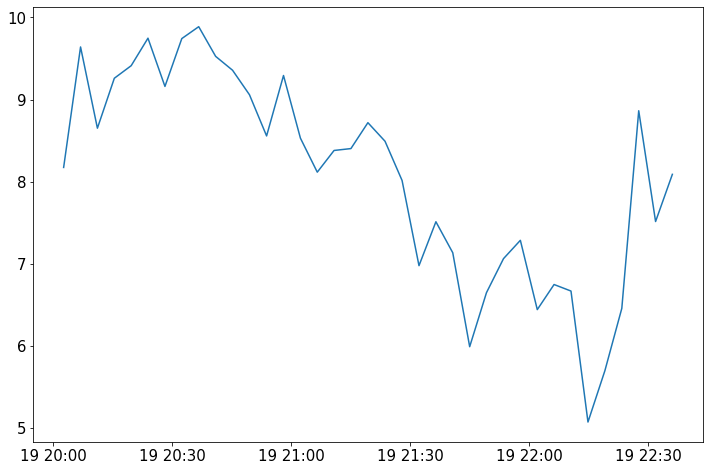

In [12]:
# Simple visualization of logarithmic time series of mean flash area OUTSIDE ZDR column region in the EC storm
plt.plot(np.log(non_zdr_foot_df.sum(axis=0) / non_zdr_ini_df.sum(axis=0)))

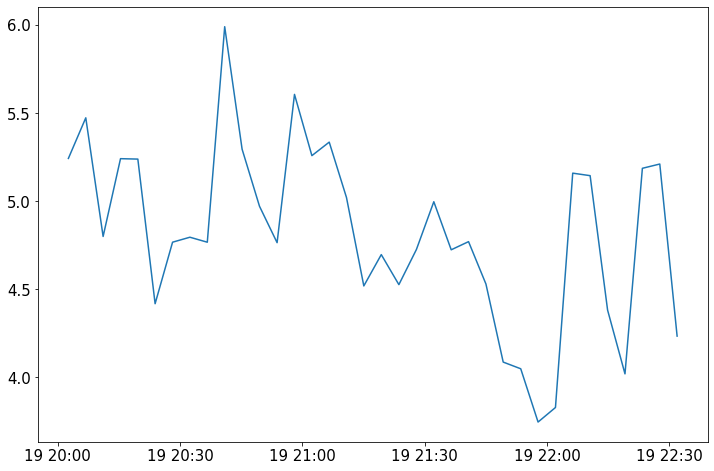

In [13]:
# Simple visualization of logarithmic time series of mean flash area WITHIN ZDR column region in the EC storm
plt.plot(np.log(zdr_foot_df.sum(axis=0) / zdr_ini_df.sum(axis=0)))

Let's concatenate the individual pandas series for mean flash area within and outside ZDR column region into a dataframe

This will help us plot both dataset on a single seaborn violin plot

In [14]:
# filter out pandas series for mean flash area within ZDR columns
filtered_data_mean_area = (zdr_foot_df.sum(axis=0) / zdr_ini_df.sum(axis=0))[
    ~np.isnan(zdr_foot_df.sum(axis=0) / zdr_ini_df.sum(axis=0))
]

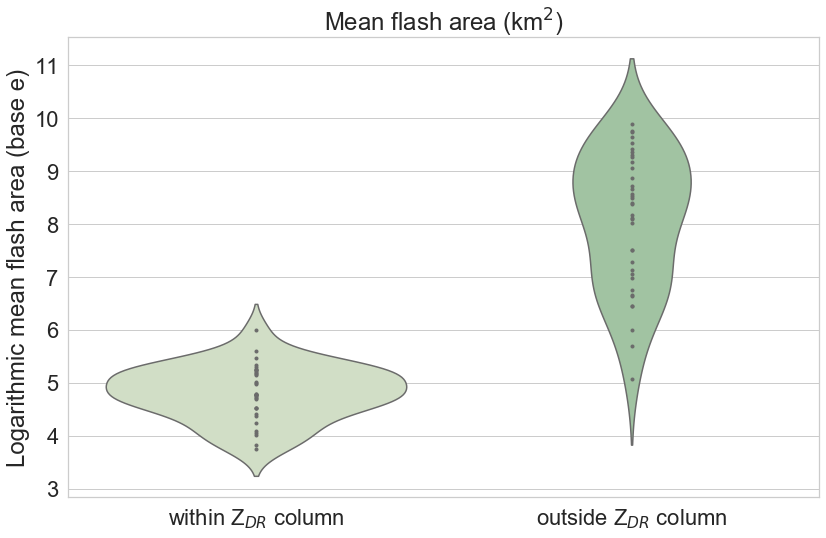

In [15]:
# plot and compare violin plots for mean flash area within and outside ZDR columns

import seaborn as sns

df_new1 = pd.DataFrame(filtered_data_mean_area, columns=["within Z$_{DR}$ column"])
df_new2 = pd.DataFrame(
    (non_zdr_foot_df.sum(axis=0) / non_zdr_ini_df.sum(axis=0)),
    columns=["outside Z$_{DR}$ column"],
)

sns_area_df = pd.concat([df_new1, df_new2], axis=1)


sns.set(style="whitegrid", font_scale=2)
# sns.set(font_scale=5)

# Use cubehelix to get a custom sequential palette
pal = sns.cubehelix_palette(5, rot=-0.5, dark=0.3)

ax = sns.violinplot(data=np.log(sns_area_df), inner="points", palette=pal)

ax.set_ylabel("Logarithmic mean flash area (base e)")
ax.set_title("Mean flash area (km$^{2}$)")
plt.tight_layout()
plt.show()

In [16]:
import numpy as np
from scipy import stats

# t-test statistics to check for significant difference between mean value for mean flash area within and outside ZDR column region

a = np.log(filtered_data_mean_area)
b = np.log(non_zdr_foot_df.sum(axis=0) / non_zdr_ini_df.sum(axis=0))

stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy="propagate")

Ttest_indResult(statistic=-14.183495683990623, pvalue=2.0945887192015957e-22)

#### Just the initiations within or outside ZDR column region

In [17]:
# filter out pandas series for flash initiations within ZDR column region
# This is done to avoid nan values that could otherwise interfere with our statistical plots and calculations

filtered_data_initiation = np.log(zdr_ini_df.sum(axis=0))[
    ~np.isinf(np.log(zdr_ini_df.sum(axis=0)))
]

/anaconda3/envs/segmentation/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


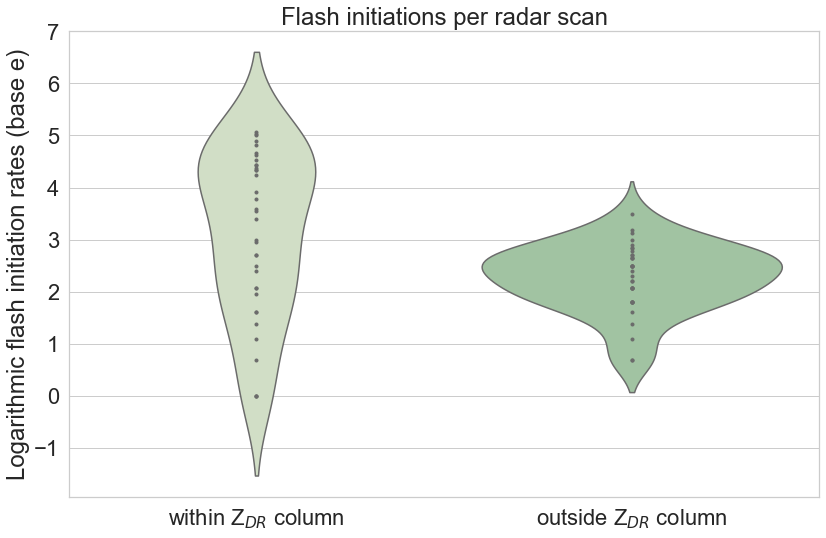

In [18]:
# Compare violin plots for #flash initiations within and outside ZDR column region

import seaborn as sns

df_new3 = pd.DataFrame(filtered_data_initiation, columns=["within Z$_{DR}$ column"])
df_new4 = pd.DataFrame(
    np.log(non_zdr_ini_df.sum(axis=0)), columns=["outside Z$_{DR}$ column"]
)

sns_ini_df = pd.concat([df_new3, df_new4], axis=1)


sns.set(style="whitegrid", font_scale=2)
# sns.set(font_scale=5)

# Use cubehelix to get a custom sequential palette
pal = sns.cubehelix_palette(5, rot=-0.5, dark=0.3)

ax = sns.violinplot(data=sns_ini_df, inner="points", palette=pal)

ax.set_ylabel("Logarithmic flash initiation rates (base e)")
ax.set_title("Flash initiations per radar scan")
plt.tight_layout()
plt.show()

In [19]:
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s


def hedges(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size

    g = (u1 - u2) / s

    g_correct = (1 - (3 / (4 * (n1 + n2) - 9))) * g
    return g_correct

In [20]:
# Calculate Hedges' g for sampling size effect to be reported along with significance tests

# Here, we do it for mean flash area
hedges(non_zdr_foot_df.sum(axis=0).values, filtered_data_mean_area.values)

0.9200620761810765

In [21]:
# and here it is for number of flash initiations

hedges(np.exp(filtered_data_initiation.values), non_zdr_ini_df.sum(axis=0).values)

1.0839920187541279

In [24]:
# t-test statistics to check for significant difference between mean value for # flash initiation within and outside ZDR column region

a = filtered_data_initiation
b = np.log(non_zdr_ini_df.sum(axis=0))

stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy="propagate")

Ttest_indResult(statistic=3.0081488318233167, pvalue=0.0036346310887472996)